<a href="https://colab.research.google.com/github/ElviraKonovalov/soen471-bigData/blob/main/elviras_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [22]:
# file = 'data/clean_data_hot-one.csv'
file = 'clean_data_hot-one.csv'
df=  pd.read_csv(file, sep=',');

In [23]:
#extract labels
y = df['INJURY']
# replace nan values with most frequent value in the column
y = y.fillna(y.value_counts().index[0])
y = y.astype('category').cat.codes
df = df.drop(columns='INJURY')

In [24]:
# extract features
X = df
X = X.drop(columns='Unnamed: 0')

In [25]:
X['INVAGE'] = X['INVAGE'].astype('category').cat.codes
X['INVAGE'] = X['INVAGE'].replace([18], X['INVAGE'].mean()).round(0).astype(int)
X['INVAGE'] = X['INVAGE'].round().astype(int)
X.rename(columns = {'INVAGE':'DRIVER_AGE'}, inplace = True)

In [26]:
X['LOCCOORD'] =  X['LOCCOORD'].fillna(X['LOCCOORD'].value_counts().index[0])
X['LOCCOORD'] = X['LOCCOORD'].astype('category').cat.codes

In [27]:
X['MANOEUVER'] = X['MANOEUVER'].astype('category').cat.codes

In [28]:
# split training and testing sets into 60% and 40%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
feature_names = list(X.columns) # get feature names

In [ ]:
# feature_names = [f"{feature}" for feature in features]

# Random Forests

In [ ]:
# find best parameters for a random forest and train using best found estimator
param_grid = {
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 5, 10, 13],
    'min_samples_leaf': [1, 2, 5, 8, 13]
}

forest = GridSearchCV(RandomForestClassifier(random_state=0), param_grid)
forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 5, 8, 13],
                         'min_samples_split': [2, 4, 5, 10, 13],
                         'n_estimators': [100, 500, 1000]})

In [ ]:
forest.best_estimator_ # params of best estimator

RandomForestClassifier(min_samples_leaf=8, n_estimators=1000, random_state=0)

## Feature importances with a forest of trees
### Feature importance based on mean decrease in impurity

In [ ]:
start_time = time.time()
importances = forest.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.114 seconds


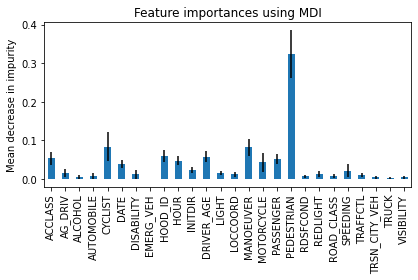

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

###  Feature importance based on feature permutation

In [ ]:
start_time = time.time()
result = permutation_importance(forest.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 99.603 seconds


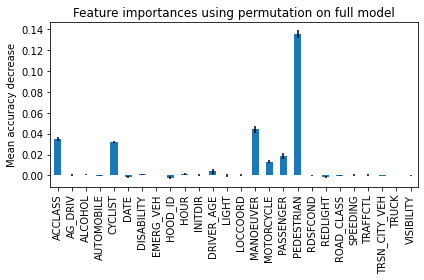

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Model evaluation

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


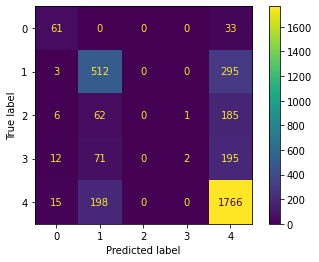

In [ ]:
y_pred = forest.best_estimator_.predict(X_test)
plot_confusion_matrix(forest.best_estimator_, y, y_test)  
plt.show();

In [ ]:
# evaluate model
import warnings
warnings.filterwarnings('ignore')
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred, average='weighted')*100,2)
recall = round(recall_score(y_test, y_pred, average='weighted')*100,2)
f1 = round(f1_score(y_test, y_pred, average='weighted')*100,2)

print("{0:40} {1:10} {2:10} {3:10} {4:}".format("--------------------------------------", "---------", "---------", "---------", "---------"))
print("{0:40} {1:10} {2:10} {3:10} {4:}".format("DATASET", "ACCURACY", "PRECISION", "RECALL", "F1"))
print("{0:40} {1:10} {2:10} {3:10} {4:}".format("--------------------------------------", "---------", "---------", "---------", "---------"))
print("{0:40} {1:} {2:10} {3:10} {4:10}".format("road collisions", accuracy, precision, recall, f1))

--------------------------------------   ---------  ---------  ---------  ---------
DATASET                                  ACCURACY   PRECISION  RECALL     F1
--------------------------------------   ---------  ---------  ---------  ---------
road collisions                          68.51      62.93      68.51       62.5


# Neural network

In [19]:
# scale features
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

mlp = MLPClassifier(random_state=0, max_iter=1000, activation='tanh', hidden_layer_sizes=(50, 100, 50), solver='adam').fit(X_train, y_train)

y_pred = mlp.predict(X_test)

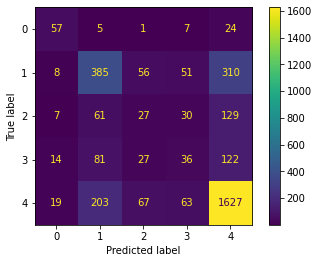

In [20]:
plot_confusion_matrix(mlp, X_test, y_test)  
plt.show();

In [21]:
# evaluate model
import warnings
warnings.filterwarnings('ignore')
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred, average='weighted')*100,2)
recall = round(recall_score(y_test, y_pred, average='weighted')*100,2)
f1 = round(f1_score(y_test, y_pred, average='weighted')*100,2)

print("{0:40} {1:10} {2:10} {3:10} {4:}".format("--------------------------------------", "---------", "---------", "---------", "---------"))
print("{0:40} {1:10} {2:10} {3:10} {4:}".format("DATASET", "ACCURACY", "PRECISION", "RECALL", "F1"))
print("{0:40} {1:10} {2:10} {3:10} {4:}".format("--------------------------------------", "---------", "---------", "---------", "---------"))
print("{0:40} {1:} {2:10} {3:10} {4:10}".format("road collisions", accuracy, precision, recall, f1))

--------------------------------------   ---------  ---------  ---------  ---------
DATASET                                  ACCURACY   PRECISION  RECALL     F1
--------------------------------------   ---------  ---------  ---------  ---------
road collisions                          62.39      59.21      62.39      60.55


In [29]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp = MLPClassifier(max_iter=100)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [30]:
clf.best_estimator_

MLPClassifier(activation='tanh', learning_rate='adaptive', max_iter=100)

In [31]:
y_pred = clf.best_estimator_.predict(X_test)

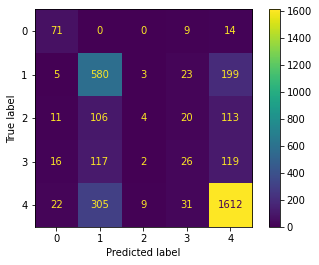

In [33]:
plot_confusion_matrix(clf.best_estimator_, X_test, y_test)  
plt.show();

In [34]:
# evaluate model
import warnings
warnings.filterwarnings('ignore')
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred, average='weighted')*100,2)
recall = round(recall_score(y_test, y_pred, average='weighted')*100,2)
f1 = round(f1_score(y_test, y_pred, average='weighted')*100,2)

print("{0:40} {1:10} {2:10} {3:10} {4:}".format("--------------------------------------", "---------", "---------", "---------", "---------"))
print("{0:40} {1:10} {2:10} {3:10} {4:}".format("DATASET", "ACCURACY", "PRECISION", "RECALL", "F1"))
print("{0:40} {1:10} {2:10} {3:10} {4:}".format("--------------------------------------", "---------", "---------", "---------", "---------"))
print("{0:40} {1:} {2:10} {3:10} {4:10}".format("road collisions", accuracy, precision, recall, f1))

--------------------------------------   ---------  ---------  ---------  ---------
DATASET                                  ACCURACY   PRECISION  RECALL     F1
--------------------------------------   ---------  ---------  ---------  ---------
road collisions                          67.11      62.96      67.11       63.7
